In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from dataloader.dataloader import DataLoader
from preprocessing.clustering_segmentation import ClusteringSegmentation
from preprocessing.edge_detection import EdgeDetection
from preprocessing.image_restoration import ImageRestorer
from preprocessing.preproccessing import ImagePreprocessor
from preprocessing.region_segmentation import RegionBasedSegmentation
from preprocessing.threshold_segmentation import ThresholdSegmentation
from feature_extraction.feature_extraction import FeatureExtractor
from feature_selection.feature_selection import FeatureSelector
from model_selection.model_selection import ModelSelection
from performance_analysis.performance_analysis import PerformanceAnalysis
from illumination_preprocessing.illumination_preprocessing import IlluminationPreprocessing

import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np

## Data Loading

In [2]:
dataloader = DataLoader(Path('./data'))

# Load Data from files
x_train, y_train, x_test, y_test, x_val, y_val = dataloader.load_data(data_augmentation=False)

In [3]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: (1445, 320, 320, 3)
y_train shape: (1445, 1)
x_test shape: (188, 320, 320, 3)
y_test shape: (188,)
x_val shape: (188, 320, 320, 3)
y_val shape: (188,)


In [ ]:
index = 20
plt.imshow(x_train[index])
plt.show()
print(f"y_train[{index}]: {y_train[index]}") 

## Preprocessing

In [4]:
illumination_processing = IlluminationPreprocessing()
illuminated_list = illumination_processing.process_images_loops(x_train)
illuminated_train = [t[0] for t in illuminated_list]
illuminated_train_mask = [t[1] for t in illuminated_list]

illuminated_list_val = illumination_processing.process_images_loops(x_val)
illuminated_val = [t[0] for t in illuminated_list_val]
illuminated_val_mask = [t[1] for t in illuminated_list_val]

In [5]:
illuminated_train = np.array(illuminated_train)
illuminated_train_mask = np.array(illuminated_train_mask)
illuminated_val = np.array(illuminated_val)
illuminated_val_mask = np.array(illuminated_val_mask)

print(f"illuminated_train shape: {illuminated_train.shape}")
print(f"illuminated_train_mask shape: {illuminated_train_mask.shape}")
print(f"illuminated_val shape: {illuminated_val.shape}")
print(f"illuminated_val_mask shape: {illuminated_val_mask.shape}")

illuminated_train shape: (1445, 320, 320)
illuminated_train_mask shape: (1445, 320, 320)
illuminated_val shape: (188, 320, 320)
illuminated_val_mask shape: (188, 320, 320)


### Edge Detection

In [16]:
edge_detection = EdgeDetection(method="canny")
edge_detected_train = edge_detection.process(illuminated_train)
edge_detected_val = edge_detection.process(illuminated_val)

print(f"edge_detected_train shape: {edge_detected_train.shape}")
print(f"edge_detected_val shape: {edge_detected_val.shape}")

edge_detected_train shape: (1445, 320, 320)
edge_detected_val shape: (188, 320, 320)


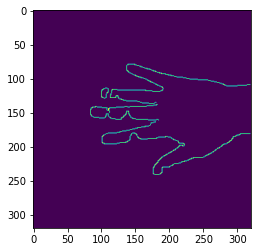

In [28]:
index = np.random.randint(0, len(edge_detected_train))
plt.imshow(edge_detected_train[index])
plt.show()

### Image resizing

In [ ]:
image_preprocessor = ImagePreprocessor()

illuminated_train, illuminated_val = image_preprocessor.resize_images(illuminated_train,illuminated_val)

In [ ]:
plt.imshow(illuminated_train[index])

## Features Extraction And Selection

In [29]:
feature_extractor = FeatureExtractor()
feature_selector = FeatureSelector()

pca_features_train = np.zeros((x_train.shape[0],0))
pca_features_val = np.zeros((x_val.shape[0],0))

In [30]:
print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

pca features train shape: (1445, 0)
pca features val shape: (188, 0)


### Hog Features

In [31]:
hog_features_train = feature_extractor.extract_hog_features(edge_detected_train)
hog_features_val = feature_extractor.extract_hog_features(edge_detected_val)

pca_hog_features_train = feature_selector.extract_pca_features(hog_features_train,load=False, num_pca_components=0.95)
pca_hog_features_val = feature_selector.extract_pca_features(hog_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_hog_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_hog_features_val), axis=1)

print(f"extracted_features shape: {hog_features_train.shape}")
print(f"extracted_features_val shape: {hog_features_val.shape}")

print(f"hog pca features train shape: {pca_hog_features_train.shape}")
print(f"hog pca features val shape: {pca_hog_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

Creating new PCA model...
extracted_features shape: (1445, 2880)
extracted_features_val shape: (188, 2880)
hog pca features train shape: (1445, 292)
hog pca features val shape: (188, 292)
pca features train shape: (1445, 292)
pca features val shape: (188, 292)


### LBP Features

In [ ]:
lbp_features_train = feature_extractor.extract_lbp_features(illuminated_train)
lbp_features_val = feature_extractor.extract_lbp_features(illuminated_val)

pca_lbp_features_train = feature_selector.extract_pca_features(lbp_features_train,load=False, num_pca_components=0.95)
pca_lbp_features_val = feature_selector.extract_pca_features(lbp_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_lbp_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_lbp_features_val), axis=1)

print(f"extracted_features shape: {lbp_features_train.shape}")
print(f"extracted_features_val shape: {lbp_features_val.shape}")

print(f"lbp pca features train shape: {pca_lbp_features_train.shape}")
print(f"lbp pca features val shape: {pca_lbp_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### SIFT Features

In [ ]:
gray_images_train = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
gray_images_val = np.zeros((x_val.shape[0], x_val.shape[1], x_val.shape[2]))

for i in range(x_train.shape[0]):
    gray_images_train[i] = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY)

for i in range(x_val.shape[0]):
    gray_images_val[i] = cv2.cvtColor(x_val[i], cv2.COLOR_BGR2GRAY)

sift_features_train = feature_extractor.extract_sift_features(illuminated_train)
sift_features_val = feature_extractor.extract_sift_features(illuminated_val)


pca_sift_features_train = feature_selector.extract_pca_features(sift_features_train,load=False, num_pca_components=0.95)
pca_sift_features_val = feature_selector.extract_pca_features(sift_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_sift_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_sift_features_val), axis=1)

print(f"extracted_features shape: {sift_features_train.shape}")
print(f"extracted_features_val shape: {sift_features_val.shape}")

print(f"sift pca features train shape: {pca_sift_features_train.shape}")
print(f"sift pca features val shape: {pca_sift_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### DAISY Features

In [ ]:
daisy_features_train = feature_extractor.extract_daisy_features(illuminated_train)
daisy_features_val = feature_extractor.extract_daisy_features(illuminated_val)

pca_daisy_features_train = feature_selector.extract_pca_features(daisy_features_train,load=False, num_pca_components=0.95)
pca_daisy_features_val = feature_selector.extract_pca_features(daisy_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_daisy_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_daisy_features_val), axis=1)

print(f"extracted_features shape: {daisy_features_train.shape}")
print(f"extracted_features_val shape: {daisy_features_val.shape}")

print(f"daisy pca features train shape: {pca_daisy_features_train.shape}")
print(f"daisy pca features val shape: {pca_daisy_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Fourier Descriptor Features

In [ ]:
fd_features_train = feature_extractor.extract_fourier_descriptor_features(illuminated_train)
fd_features_val = feature_extractor.extract_fourier_descriptor_features(illuminated_val)

pca_fd_features_train = feature_selector.extract_pca_features(fd_features_train,load=False, num_pca_components=0.95)
pca_fd_features_val = feature_selector.extract_pca_features(fd_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_fd_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_fd_features_val), axis=1)

print(f"extracted_features shape: {fd_features_train.shape}")
print(f"extracted_features_val shape: {fd_features_val.shape}")

print(f"fd pca features train shape: {pca_fd_features_train.shape}")
print(f"fd pca features val shape: {pca_fd_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### ORB Features

In [ ]:
orb_features_train = feature_extractor.extract_orb_features(illuminated_train)
orb_features_val = feature_extractor.extract_orb_features(illuminated_val)

pca_orb_features_train = feature_selector.extract_pca_features(orb_features_train,load=False, num_pca_components=0.95)
pca_orb_features_val = feature_selector.extract_pca_features(orb_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_orb_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_orb_features_val), axis=1)

print(f"extracted_features shape: {orb_features_train.shape}")
print(f"extracted_features_val shape: {orb_features_val.shape}")

print(f"orb pca features train shape: {pca_orb_features_train.shape}")
print(f"orb pca features val shape: {pca_orb_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### RI HOG Features

In [ ]:
ri_hog_features_train = feature_extractor.RI_HOG(illuminated_train_mask)
ri_hog_features_val = feature_extractor.RI_HOG(illuminated_val_mask)

pca_ri_hog_features_train = feature_selector.extract_pca_features(ri_hog_features_train,load=False, num_pca_components=0.95)
pca_ri_hog_features_val = feature_selector.extract_pca_features(ri_hog_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_ri_hog_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_ri_hog_features_val), axis=1)

print(f"extracted_features shape: {ri_hog_features_train.shape}")
print(f"extracted_features_val shape: {ri_hog_features_val.shape}")

print(f"ri_hog pca features train shape: {pca_ri_hog_features_train.shape}")
print(f"ri_hog pca features val shape: {pca_ri_hog_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Hu moments Features

In [ ]:
hu_moment_features_train = feature_extractor.extract_hu_moments_features(illuminated_train_mask)
hu_moment_features_val = feature_extractor.extract_hu_moments_features(illuminated_val_mask)

pca_hu_moment_features_train = feature_selector.extract_pca_features(hu_moment_features_train,load=False, num_pca_components=0.95)
pca_hu_moment_features_val = feature_selector.extract_pca_features(hu_moment_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_hu_moment_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_hu_moment_features_val), axis=1)

print(f"extracted_features shape: {hu_moment_features_train.shape}")
print(f"extracted_features_val shape: {hu_moment_features_val.shape}")

print(f"hu_moment pca features train shape: {pca_hu_moment_features_train.shape}")
print(f"hu_moment pca features val shape: {pca_hu_moment_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Convex Hull Features

In [ ]:
convex_hull_features_train = feature_extractor.extract_convex_hull_features(illuminated_train_mask)
convex_hull_features_val = feature_extractor.extract_convex_hull_features(illuminated_val_mask)

pca_convex_hull_features_train = feature_selector.extract_pca_features(convex_hull_features_train,load=False, num_pca_components=0.95)
pca_convex_hull_features_val = feature_selector.extract_pca_features(convex_hull_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_convex_hull_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_convex_hull_features_val), axis=1)

print(f"extracted_features shape: {convex_hull_features_train.shape}")
print(f"extracted_features_val shape: {convex_hull_features_val.shape}")

print(f"convex_hull pca features train shape: {pca_convex_hull_features_train.shape}")
print(f"convex_hull pca features val shape: {pca_convex_hull_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Eliiptical fourier descriptors features

In [ ]:
elliptical_fd_features_train = feature_extractor.elliptical_fourier_descriptors(illuminated_train_mask)
elliptical_fd_features_val = feature_extractor.elliptical_fourier_descriptors(illuminated_val_mask)

pca_elliptic_fd_features_train = feature_selector.extract_pca_features(elliptical_fd_features_train,load=False, num_pca_components=0.95)
pca_elliptic_fd_features_val = feature_selector.extract_pca_features(elliptical_fd_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_elliptic_fd_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_elliptic_fd_features_val), axis=1)

print(f"extracted_features shape: {elliptical_fd_features_train.shape}")
print(f"extracted_features_val shape: {elliptical_fd_features_val.shape}")

print(f"elliptic_fd pca features train shape: {pca_elliptic_fd_features_train.shape}")
print(f"elliptic_fd pca features val shape: {pca_elliptic_fd_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

## PCA

In [32]:
# # PCA FEATURES

# pca_features_train = feature_selector.extract_pca_features(extracted_features, load=False, num_pca_components=0.85)
# pca_features_val = feature_selector.extract_pca_features(extracted_features_val, load=True, num_pca_components=0.85)

print(f"pca_features_train shape: {pca_features_train.shape}")
print(f"pca_features_val shape: {pca_features_val.shape}")

pca_features_train shape: (1445, 292)
pca_features_val shape: (188, 292)


### Normalizing the PCA extracted features

In [33]:
extracted_features_train_mean = pca_features_train.mean(axis=0)
extracted_features_train_std = pca_features_train.std(axis=0)

In [34]:
pca_features_train = (pca_features_train - extracted_features_train_mean) /extracted_features_train_std
pca_features_val = (pca_features_val - extracted_features_train_mean) /extracted_features_train_std

extracted_features_train_mean = pca_features_train.mean(axis=0)
extracted_features_train_std = pca_features_train.std(axis=0)

## Models

In [40]:
model_selection = ModelSelection(pca_features_train, y_train, pca_features_val, y_val)

svm, pred_train, pred_val = model_selection.SVM()
performance_analysis = PerformanceAnalysis('SVM Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('SVM VALIDATION', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()


knn, pred_train, pred_val = model_selection.KNN()
performance_analysis = PerformanceAnalysis('KNN Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('KNN VALIDATION', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()

ensemble, pred_train, pred_val = model_selection.Ensemble()
performance_analysis = PerformanceAnalysis('Ensemble Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('Ensemble VALIDATION', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()


adaboost, pred_train, pred_val = model_selection.AdaBoost()
performance_analysis = PerformanceAnalysis('AdaBoost Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('AdaBoost VALIDATION', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()

c:\Users\EGYPT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: SVM Train
Accuracy: 100.0%


*****************************************
Model: SVM VALIDATION
Accuracy: 49.47%
*****************************************

This text has default colors.


c:\Users\EGYPT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model: KNN Train
Accuracy: 68.51%


*****************************************
Model: KNN VALIDATION
Accuracy: 39.36%
*****************************************

This text has default colors.


d:\Senior II\Pattern Recognition\Project\Project-Pattern-Recognition\model_selection\model_selection.py:139: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(self.x_train, self.y_train)


Model: Ensemble Train
Accuracy: 100.0%


*****************************************
Model: Ensemble VALIDATION
Accuracy: 46.28%
*****************************************

This text has default colors.


c:\Users\EGYPT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: AdaBoost Train
Accuracy: 48.1%


*****************************************
Model: AdaBoost VALIDATION
Accuracy: 43.09%
*****************************************

This text has default colors.


In [41]:
ann, pred_train, pred_val = model_selection.ANN(input_dim=pca_features_train.shape[1], 
                                                output_dim=6)
performance_analysis = PerformanceAnalysis('ANN Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('ANN Val', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()

input_dim: 292
output_dim: 6
x_train: (1445, 292)
y_train: (1445, 1)
y_onehot: (1445, 6)
Epoch 1/10
46/46 [==============================] - 1s 13ms/step - loss: 4.8236 - accuracy: 0.3294 - val_loss: 4.0405 - val_accuracy: 0.4894
Epoch 2/10
46/46 [==============================] - 0s 6ms/step - loss: 2.8726 - accuracy: 0.8630 - val_loss: 3.1026 - val_accuracy: 0.5585
Epoch 3/10
46/46 [==============================] - 0s 5ms/step - loss: 1.8821 - accuracy: 0.9730 - val_loss: 2.6543 - val_accuracy: 0.5957
Epoch 4/10
46/46 [==============================] - 0s 6ms/step - loss: 1.2733 - accuracy: 0.9958 - val_loss: 2.2573 - val_accuracy: 0.5585
Epoch 5/10
46/46 [==============================] - 0s 5ms/step - loss: 0.8579 - accuracy: 0.9986 - val_loss: 1.9237 - val_accuracy: 0.5904
Epoch 6/10
46/46 [==============================] - 0s 5ms/step - loss: 0.5948 - accuracy: 0.9972 - val_loss: 1.7745 - val_accuracy: 0.5904
Epoch 7/10
46/46 [==============================] - 0s 5ms/step - loss